# Recurrent Neural Network

We're going to build a Recurrent Neural Network from scratch and look at the math behind it.

## Representing tokens or text

Firstly, we have to create a proper input sequence from the input data.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

Here we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings. 

### One-hot encoding over vocabulary

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [1]:
import numpy as np

# Set seed such that we always get the same dataset
np.random.seed(42)

def generate_dataset(num_sequences=100):
    """
    Generates a number of sequences as our dataset.
    
    Args:
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 10)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [2]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: num_words)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'b\' is', word_to_idx['b'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

We have 100 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'


## Partitioning the dataset

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training, validation and test sets. 80%, 10% and 10% is a common distribution, but mind you that this largely depends on the size of the dataset. Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.

We can use PyTorch's `Dataset` class to build a simple dataset where we can easily retrieve (inputs, targets) pairs for each of our sequences.

In [3]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 80 samples in the training set.
We have 10 samples in the validation set.
We have 10 samples in the test set.


When working with more complex data than what we use in this exercise, creating a PyTorch `DataLoader` on top of the dataset can be beneficial. A data loader is basically a fancy generator/iterator that we can use to abstract away all of the data handling and pre-processing + it's super useful for processing batches of data as well! Data loaders will come in handy later when you start to work on your projects, so be sure to check them out!

For more information on how to use datasets and data loaders in PyTorch, [consult the official guide](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [4]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' has shape (2, 4, 1).


Great! Now that we have our one-hot encodings in place, we can move on to the RNNs!

# Introduction to Recurrent Neural Networks (RNN)

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$

Reading material: [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Implementing a RNN

We will implement the forward pass, backward pass, optimization and training loop for a RNN in numpy so that you can get familiar with the recurrent nature of RNNs.

Let's define the necessary model parameters. Recall that an $n \times m$ weight matrix maps $\mathbb{R}^{m} \rightarrow \mathbb{R}^{n}$.

In [22]:
hidden_size = 100 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Initializes our recurrent neural network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
    """
    # Weight matrix (input to hidden state)
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    b_out = np.zeros((vocab_size, 1))
    
    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

### Function Definitions
Below we have defined the `sigmoid`, `tanh` and `softmax` functions.

In [7]:
# Hyperbolic Tangent activation
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

#Sigmoid Activation
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f
    
#Softmax
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

### Implement the forward pass

Now that we have all the definitions in place, we can start to implement a forward pass. In the forward pass, it should return the output state as well as the hidden state of the RNN.

In [11]:
def forward_pass(inputs, hidden_state, params):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `hidden_state`: an already initialized hidden state
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Compute output
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states

### Implement the backward pass

Now let us implement backpropogation for the RNN. The backward pass should return the gradient and loss of the forward pass

In [12]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss (as a scalar)
        loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])
        
        # Backpropagate into output (derivative of cross-entropy)
        # if you're confused about this step, see this link for an explanation:
        # http://cs231n.github.io/neural-networks-case-study/#grad
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Backpropagate into W
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Backpropagate into h
        d_h = np.dot(W.T, d_o) + d_h_next
        
        # Backpropagate through non-linearity
        d_f = tanh(hidden_states[t], derivative=True) * d_h
        d_b_hidden += d_f
        
        # Backpropagate into U
        d_U += np.dot(d_f, inputs[t].T)
        
        # Backpropagate into V
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads

### Optimization

Now that we can do forward passes and compute gradients with backpropagation, we're ready to train our network. For that we will need an optimizer. A common and easy to implement optimization method is gradient descent, which has the update rule: $\theta_{n+1} = \theta_{n} - \eta \frac{\partial E}{\partial \theta_{n}}$, where $\eta$ is the learning rate and $E$ is our cost function. This is essentially what's going on behind the scenes when you run `optimizer.step()` in PyTorch using the stochastic gradient descent optimizer.

In [13]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

### Training Loop

We need to define a full training loop with a forward pass, backward pass, optimization step and validation. 

Epoch 0, training loss: 3.65866644795313, validation loss: 3.7032161847057323
Epoch 1000, training loss: 1.1711244006213168, validation loss: 1.2073167880752573
Epoch 2000, training loss: 1.038806951371775, validation loss: 1.0662285729488796
Epoch 3000, training loss: 1.0601318963607338, validation loss: 1.0861394450842101
Epoch 4000, training loss: 1.1869567937693926, validation loss: 1.2298118957773625
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['a', 'b', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


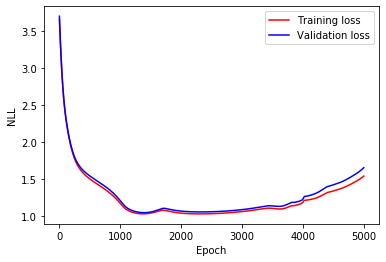

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 5000

# Initialize a new network
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')
        
        # Update parameters
        params = update_parameters(params, grads, lr=3e-4)
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 1000 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Prediction

Now that we have trained a RNN model, it's time to put it to test. We will provide the network with a starting sentence and let it predict the ouput.

In [24]:
def predict(params, sentence='', num_generate=4):
    """
    Takes in a sentence as a string and outputs a sequence
    based on the predictions of the RNN.
    
    Args:
     `params`: the parameters of the network
     `sentence`: string with whitespace-separated tokens
     `num_generate`: the number of tokens to generate
    """
    sentence = sentence.split(' ')
    
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    
    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Generate hidden state for sentence
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    
    # Output sentence
    output_sentence = sentence
    
    # Append first prediction
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    
    # Forward pass
    for i in range(num_generate):

        # Get the latest prediction and latest hidden state
        output = outputs[-1]
        hidden_state = hidden_states[-1]
    
        # Reshape our output to match the input shape of our forward pass
        output = output.reshape(1, output.shape[0], output.shape[1])
    
        # Forward pass
        outputs, hidden_states = forward_pass(output, hidden_state, params)
        
        # Compute the index the most likely word and look up the corresponding word
        word = idx_to_word[np.argmax(outputs)]
        
        output_sentence.append(word)
        
    return output_sentence
    
# Perform freestyle
print('Example:')
print(predict(params, sentence='a a a a a b'))

Example:
['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'EOS']


You do get a good result with a simple RNN and it is also able to predict a new sequence accurately enough.